# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:45 - loss: 0.6942

  30/1875 [..............................] - ETA: 3s - loss: 0.5379   

  60/1875 [..............................] - ETA: 3s - loss: 0.4581

  90/1875 [>.............................] - ETA: 3s - loss: 0.4170

 121/1875 [>.............................] - ETA: 2s - loss: 0.3901

 152/1875 [=>............................] - ETA: 2s - loss: 0.3709

 183/1875 [=>............................] - ETA: 2s - loss: 0.3560

 215/1875 [==>...........................] - ETA: 2s - loss: 0.3435

 247/1875 [==>...........................] - ETA: 2s - loss: 0.3330

 278/1875 [===>..........................] - ETA: 2s - loss: 0.3241

 308/1875 [===>..........................] - ETA: 2s - loss: 0.3166

 336/1875 [====>.........................] - ETA: 2s - loss: 0.3103

 367/1875 [====>.........................] - ETA: 2s - loss: 0.3039

 399/1875 [=====>........................] - ETA: 2s - loss: 0.2980

 428/1875 [=====>........................] - ETA: 2s - loss: 0.2931

 456/1875 [======>.......................] - ETA: 2s - loss: 0.2887

 487/1875 [======>.......................] - ETA: 2s - loss: 0.2841

 518/1875 [=======>......................] - ETA: 2s - loss: 0.2799

 547/1875 [=======>......................] - ETA: 2s - loss: 0.2762

 578/1875 [========>.....................] - ETA: 2s - loss: 0.2725

 608/1875 [========>.....................] - ETA: 2s - loss: 0.2691

 639/1875 [=========>....................] - ETA: 2s - loss: 0.2658

 671/1875 [=========>....................] - ETA: 2s - loss: 0.2626

 701/1875 [==========>...................] - ETA: 1s - loss: 0.2598

 732/1875 [==========>...................] - ETA: 1s - loss: 0.2570

 761/1875 [===========>..................] - ETA: 1s - loss: 0.2545

 792/1875 [===========>..................] - ETA: 1s - loss: 0.2520

 823/1875 [============>.................] - ETA: 1s - loss: 0.2495

 854/1875 [============>.................] - ETA: 1s - loss: 0.2472

 887/1875 [=============>................] - ETA: 1s - loss: 0.2449

 917/1875 [=============>................] - ETA: 1s - loss: 0.2428

 947/1875 [==============>...............] - ETA: 1s - loss: 0.2408

 976/1875 [==============>...............] - ETA: 1s - loss: 0.2390

1000/1875 [===============>..............] - ETA: 1s - loss: 0.2375

1029/1875 [===============>..............] - ETA: 1s - loss: 0.2358

1058/1875 [===============>..............] - ETA: 1s - loss: 0.2341

1088/1875 [================>.............] - ETA: 1s - loss: 0.2325

1119/1875 [================>.............] - ETA: 1s - loss: 0.2308

1149/1875 [=================>............] - ETA: 1s - loss: 0.2293

1178/1875 [=================>............] - ETA: 1s - loss: 0.2278

1206/1875 [==================>...........] - ETA: 1s - loss: 0.2264

1235/1875 [==================>...........] - ETA: 1s - loss: 0.2251

1268/1875 [===================>..........] - ETA: 1s - loss: 0.2235

1300/1875 [===================>..........] - ETA: 0s - loss: 0.2221

1333/1875 [====================>.........] - ETA: 0s - loss: 0.2207

1366/1875 [====================>.........] - ETA: 0s - loss: 0.2193

1398/1875 [=====================>........] - ETA: 0s - loss: 0.2180

1427/1875 [=====================>........] - ETA: 0s - loss: 0.2168

1457/1875 [======================>.......] - ETA: 0s - loss: 0.2157

1489/1875 [======================>.......] - ETA: 0s - loss: 0.2145

1518/1875 [=======================>......] - ETA: 0s - loss: 0.2134

1547/1875 [=======================>......] - ETA: 0s - loss: 0.2124

1576/1875 [========================>.....] - ETA: 0s - loss: 0.2114

1606/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1635/1875 [=========================>....] - ETA: 0s - loss: 0.2094

1664/1875 [=========================>....] - ETA: 0s - loss: 0.2084

1694/1875 [==========================>...] - ETA: 0s - loss: 0.2074

1726/1875 [==========================>...] - ETA: 0s - loss: 0.2064

1757/1875 [===========================>..] - ETA: 0s - loss: 0.2055

1789/1875 [===========================>..] - ETA: 0s - loss: 0.2045

1821/1875 [============================>.] - ETA: 0s - loss: 0.2036

1852/1875 [============================>.] - ETA: 0s - loss: 0.2027

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2020


Epoch 2/5


   1/1875 [..............................] - ETA: 4s - loss: 0.1055

  20/1875 [..............................] - ETA: 4s - loss: 0.1098

  49/1875 [..............................] - ETA: 3s - loss: 0.1099

  79/1875 [>.............................] - ETA: 3s - loss: 0.1098

 107/1875 [>.............................] - ETA: 3s - loss: 0.1097

 138/1875 [=>............................] - ETA: 3s - loss: 0.1096

 169/1875 [=>............................] - ETA: 3s - loss: 0.1096

 199/1875 [==>...........................] - ETA: 3s - loss: 0.1096

 228/1875 [==>...........................] - ETA: 2s - loss: 0.1096

 258/1875 [===>..........................] - ETA: 2s - loss: 0.1095

 288/1875 [===>..........................] - ETA: 2s - loss: 0.1095

 318/1875 [====>.........................] - ETA: 2s - loss: 0.1094

 346/1875 [====>.........................] - ETA: 2s - loss: 0.1094

 378/1875 [=====>........................] - ETA: 2s - loss: 0.1093

 412/1875 [=====>........................] - ETA: 2s - loss: 0.1093

 446/1875 [======>.......................] - ETA: 2s - loss: 0.1092

 480/1875 [======>.......................] - ETA: 2s - loss: 0.1091

 513/1875 [=======>......................] - ETA: 2s - loss: 0.1091

 543/1875 [=======>......................] - ETA: 2s - loss: 0.1090

 574/1875 [========>.....................] - ETA: 2s - loss: 0.1090

 607/1875 [========>.....................] - ETA: 2s - loss: 0.1089

 641/1875 [=========>....................] - ETA: 2s - loss: 0.1088

 668/1875 [=========>....................] - ETA: 2s - loss: 0.1088

 689/1875 [==========>...................] - ETA: 2s - loss: 0.1087

 712/1875 [==========>...................] - ETA: 2s - loss: 0.1087

 742/1875 [==========>...................] - ETA: 1s - loss: 0.1086

 772/1875 [===========>..................] - ETA: 1s - loss: 0.1085

 800/1875 [===========>..................] - ETA: 1s - loss: 0.1085

 829/1875 [============>.................] - ETA: 1s - loss: 0.1084

 858/1875 [============>.................] - ETA: 1s - loss: 0.1083

 887/1875 [=============>................] - ETA: 1s - loss: 0.1083

 917/1875 [=============>................] - ETA: 1s - loss: 0.1082

 946/1875 [==============>...............] - ETA: 1s - loss: 0.1081

 976/1875 [==============>...............] - ETA: 1s - loss: 0.1081

1001/1875 [===============>..............] - ETA: 1s - loss: 0.1080

1030/1875 [===============>..............] - ETA: 1s - loss: 0.1080

1059/1875 [===============>..............] - ETA: 1s - loss: 0.1079

1089/1875 [================>.............] - ETA: 1s - loss: 0.1078

1119/1875 [================>.............] - ETA: 1s - loss: 0.1078

1147/1875 [=================>............] - ETA: 1s - loss: 0.1077

1172/1875 [=================>............] - ETA: 1s - loss: 0.1077

1202/1875 [==================>...........] - ETA: 1s - loss: 0.1076

1232/1875 [==================>...........] - ETA: 1s - loss: 0.1076

1263/1875 [===================>..........] - ETA: 1s - loss: 0.1075

1291/1875 [===================>..........] - ETA: 1s - loss: 0.1075

1319/1875 [====================>.........] - ETA: 0s - loss: 0.1074

1347/1875 [====================>.........] - ETA: 0s - loss: 0.1073

1377/1875 [=====================>........] - ETA: 0s - loss: 0.1073

1405/1875 [=====================>........] - ETA: 0s - loss: 0.1072

1435/1875 [=====================>........] - ETA: 0s - loss: 0.1072

1466/1875 [======================>.......] - ETA: 0s - loss: 0.1071

1495/1875 [======================>.......] - ETA: 0s - loss: 0.1071

1524/1875 [=======================>......] - ETA: 0s - loss: 0.1070

1554/1875 [=======================>......] - ETA: 0s - loss: 0.1070

1583/1875 [========================>.....] - ETA: 0s - loss: 0.1069

1612/1875 [========================>.....] - ETA: 0s - loss: 0.1069

1642/1875 [=========================>....] - ETA: 0s - loss: 0.1068

1674/1875 [=========================>....] - ETA: 0s - loss: 0.1068

1703/1875 [==========================>...] - ETA: 0s - loss: 0.1067

1735/1875 [==========================>...] - ETA: 0s - loss: 0.1067

1766/1875 [===========================>..] - ETA: 0s - loss: 0.1066

1798/1875 [===========================>..] - ETA: 0s - loss: 0.1066

1829/1875 [============================>.] - ETA: 0s - loss: 0.1065

1853/1875 [============================>.] - ETA: 0s - loss: 0.1065

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1064


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1005

  32/1875 [..............................] - ETA: 3s - loss: 0.0977

  63/1875 [>.............................] - ETA: 3s - loss: 0.0977

  93/1875 [>.............................] - ETA: 2s - loss: 0.0977

 122/1875 [>.............................] - ETA: 2s - loss: 0.0977

 149/1875 [=>............................] - ETA: 2s - loss: 0.0977

 180/1875 [=>............................] - ETA: 2s - loss: 0.0977

 211/1875 [==>...........................] - ETA: 2s - loss: 0.0977

 243/1875 [==>...........................] - ETA: 2s - loss: 0.0977

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0978

 304/1875 [===>..........................] - ETA: 2s - loss: 0.0978

 334/1875 [====>.........................] - ETA: 2s - loss: 0.0978

 364/1875 [====>.........................] - ETA: 2s - loss: 0.0978

 395/1875 [=====>........................] - ETA: 2s - loss: 0.0978

 424/1875 [=====>........................] - ETA: 2s - loss: 0.0978

 455/1875 [======>.......................] - ETA: 2s - loss: 0.0978

 487/1875 [======>.......................] - ETA: 2s - loss: 0.0978

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 578/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 608/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 640/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 669/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 699/1875 [==========>...................] - ETA: 1s - loss: 0.0979

 729/1875 [==========>...................] - ETA: 1s - loss: 0.0979

 758/1875 [===========>..................] - ETA: 1s - loss: 0.0979

 786/1875 [===========>..................] - ETA: 1s - loss: 0.0979

 818/1875 [============>.................] - ETA: 1s - loss: 0.0979

 851/1875 [============>.................] - ETA: 1s - loss: 0.0979

 884/1875 [=============>................] - ETA: 1s - loss: 0.0979

 917/1875 [=============>................] - ETA: 1s - loss: 0.0979

 949/1875 [==============>...............] - ETA: 1s - loss: 0.0979

 980/1875 [==============>...............] - ETA: 1s - loss: 0.0979

1013/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1037/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1068/1875 [================>.............] - ETA: 1s - loss: 0.0979

1095/1875 [================>.............] - ETA: 1s - loss: 0.0979

1126/1875 [=================>............] - ETA: 1s - loss: 0.0979

1157/1875 [=================>............] - ETA: 1s - loss: 0.0979

1185/1875 [=================>............] - ETA: 1s - loss: 0.0978

1217/1875 [==================>...........] - ETA: 1s - loss: 0.0978

1249/1875 [==================>...........] - ETA: 1s - loss: 0.0978

1281/1875 [===================>..........] - ETA: 0s - loss: 0.0978

1314/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1378/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1437/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1468/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1498/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1592/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1834/1875 [============================>.] - ETA: 0s - loss: 0.0977

1865/1875 [============================>.] - ETA: 0s - loss: 0.0977

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0977


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0977

  34/1875 [..............................] - ETA: 2s - loss: 0.0959

  65/1875 [>.............................] - ETA: 2s - loss: 0.0960

  97/1875 [>.............................] - ETA: 2s - loss: 0.0960

 128/1875 [=>............................] - ETA: 2s - loss: 0.0961

 159/1875 [=>............................] - ETA: 2s - loss: 0.0961

 189/1875 [==>...........................] - ETA: 2s - loss: 0.0961

 219/1875 [==>...........................] - ETA: 2s - loss: 0.0961

 249/1875 [==>...........................] - ETA: 2s - loss: 0.0961

 277/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 309/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 340/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 368/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 396/1875 [=====>........................] - ETA: 2s - loss: 0.0961

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0961

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0961

 490/1875 [======>.......................] - ETA: 2s - loss: 0.0961

 520/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 581/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 613/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 644/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 674/1875 [=========>....................] - ETA: 1s - loss: 0.0961

 703/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 732/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 763/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 791/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 816/1875 [============>.................] - ETA: 1s - loss: 0.0961

 843/1875 [============>.................] - ETA: 1s - loss: 0.0961

 874/1875 [============>.................] - ETA: 1s - loss: 0.0961

 902/1875 [=============>................] - ETA: 1s - loss: 0.0961

 934/1875 [=============>................] - ETA: 1s - loss: 0.0961

 963/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0961

1025/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1056/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1088/1875 [================>.............] - ETA: 1s - loss: 0.0961

1114/1875 [================>.............] - ETA: 1s - loss: 0.0961

1144/1875 [=================>............] - ETA: 1s - loss: 0.0961

1174/1875 [=================>............] - ETA: 1s - loss: 0.0961

1205/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1236/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1289/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1311/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1331/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1362/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1389/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1419/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1480/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1509/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1540/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1699/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1819/1875 [============================>.] - ETA: 0s - loss: 0.0960

1848/1875 [============================>.] - ETA: 0s - loss: 0.0960

1873/1875 [============================>.] - ETA: 0s - loss: 0.0960

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0960


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0892

  33/1875 [..............................] - ETA: 2s - loss: 0.0931

  65/1875 [>.............................] - ETA: 2s - loss: 0.0941

  94/1875 [>.............................] - ETA: 2s - loss: 0.0944

 124/1875 [>.............................] - ETA: 2s - loss: 0.0945

 155/1875 [=>............................] - ETA: 2s - loss: 0.0946

 185/1875 [=>............................] - ETA: 2s - loss: 0.0947

 215/1875 [==>...........................] - ETA: 2s - loss: 0.0947

 248/1875 [==>...........................] - ETA: 2s - loss: 0.0948

 277/1875 [===>..........................] - ETA: 2s - loss: 0.0948

 308/1875 [===>..........................] - ETA: 2s - loss: 0.0948

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0948

 372/1875 [====>.........................] - ETA: 2s - loss: 0.0949

 404/1875 [=====>........................] - ETA: 2s - loss: 0.0949

 436/1875 [=====>........................] - ETA: 2s - loss: 0.0949

 469/1875 [======>.......................] - ETA: 2s - loss: 0.0949

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0949

 535/1875 [=======>......................] - ETA: 2s - loss: 0.0949

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0949

 603/1875 [========>.....................] - ETA: 2s - loss: 0.0950

 636/1875 [=========>....................] - ETA: 1s - loss: 0.0950

 668/1875 [=========>....................] - ETA: 1s - loss: 0.0950

 697/1875 [==========>...................] - ETA: 1s - loss: 0.0950

 727/1875 [==========>...................] - ETA: 1s - loss: 0.0950

 757/1875 [===========>..................] - ETA: 1s - loss: 0.0950

 790/1875 [===========>..................] - ETA: 1s - loss: 0.0950

 823/1875 [============>.................] - ETA: 1s - loss: 0.0950

 853/1875 [============>.................] - ETA: 1s - loss: 0.0951

 884/1875 [=============>................] - ETA: 1s - loss: 0.0951

 914/1875 [=============>................] - ETA: 1s - loss: 0.0951

 946/1875 [==============>...............] - ETA: 1s - loss: 0.0951

 978/1875 [==============>...............] - ETA: 1s - loss: 0.0951

1007/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1038/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1068/1875 [================>.............] - ETA: 1s - loss: 0.0951

1099/1875 [================>.............] - ETA: 1s - loss: 0.0951

1129/1875 [=================>............] - ETA: 1s - loss: 0.0951

1160/1875 [=================>............] - ETA: 1s - loss: 0.0951

1189/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1218/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1249/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1275/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1303/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1331/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1361/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1390/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1452/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1483/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1514/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1576/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1785/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1842/1875 [============================>.] - ETA: 0s - loss: 0.0952

1871/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

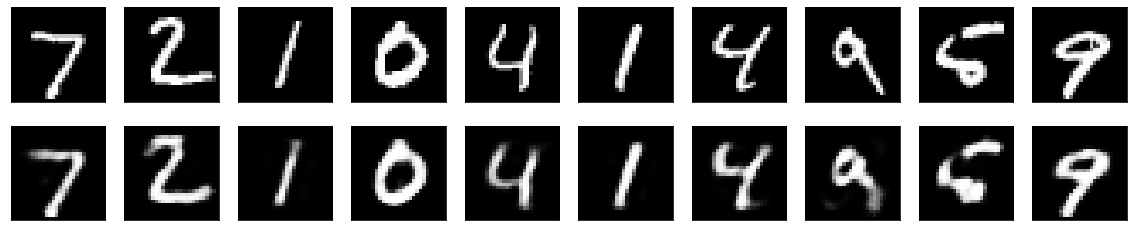

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
